In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity, corticostriatal
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_str_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi

plasticity = ThresholdPlasticityRule(x_f=0.85, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
network = RateNetwork([ctx, d1], J, formulation=3, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


### Simulation

In [4]:
# # Specific input
init_inputs = [np.zeros(len(patterns[0][0])),
               patterns[1][0]]

T=1#ms
mouse = ReachingTask()
network.simulate_euler2(T, init_inputs[0], init_inputs[1])
# network.simulate_learning(mouse, T, init_inputs, patterns, plasticity, (40, 1400, 0.05, 0.6), noise=[0.13,0.13,0.13], 
#                           b = [0.05, 0.013, 0.02, 0.05], env=5, learning=False, r_ext=[lambda t:0, lambda t: 1], print_output=False, disable_pbar=False)

INFO:network:Integrating network dynamics
100%|██████████| 999/999 [00:18<00:00, 54.07it/s]


### Results

In [5]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.po725206ps[2])
# filename = 'simulation-test'
np.savez('/work/jp464/striatum-sequence/' + 'simulation-pre-learning' + '.npz', 
         overlaps_ctx=overlaps_ctx, overlaps_d1=overlaps_d1, 
         state_ctx=network.pops[0].state, state_d1=network.pops[1].state)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 181.20it/s]
INFO:sequences:Computing overlaps
100%|██████████| 12/12 [00:00<00:00, 955.57it/s]


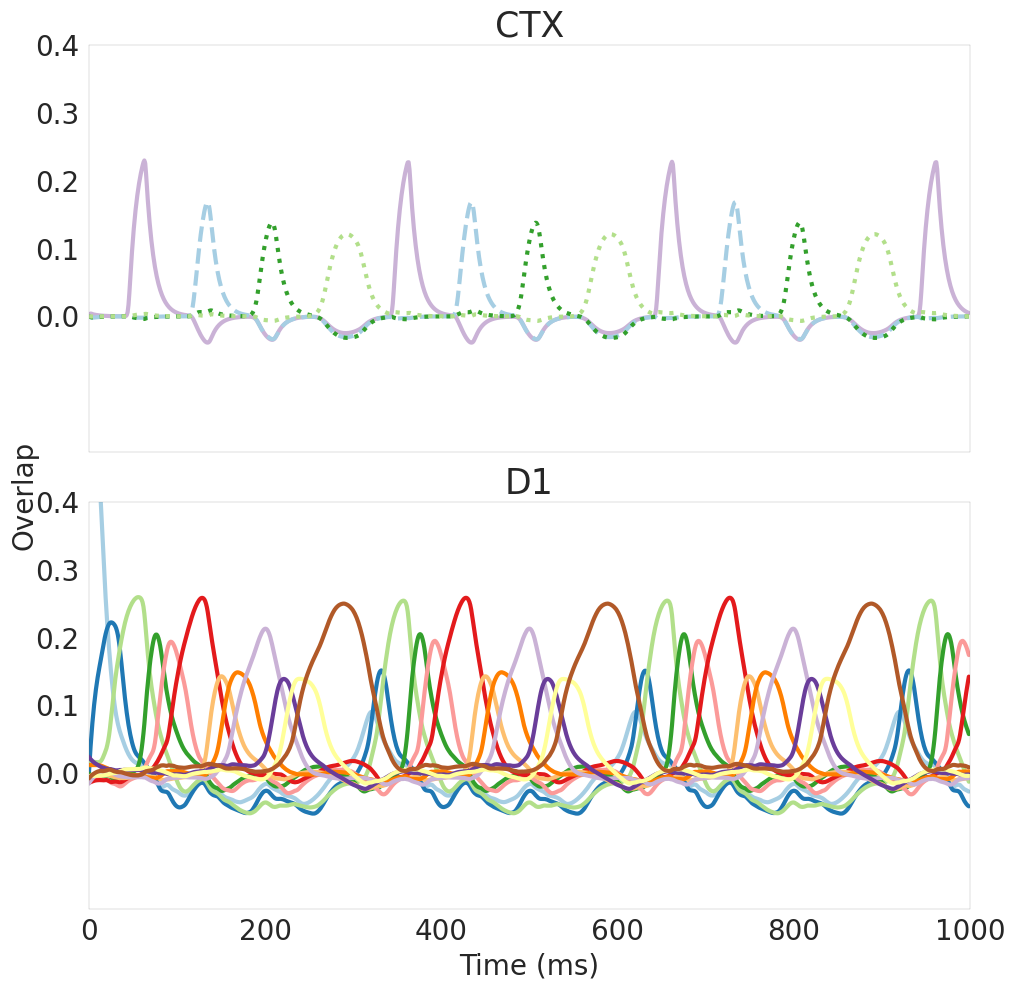

In [6]:
sns.set_style('white') 
colors = sns.color_palette('Paired')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
for i in range(12):
    axes[1].plot(overlaps_d1[i], linestyle='solid', linewidth=3, color=colors[i])
# axes[1].plot(overlaps_d1[4], linestyle='dotted', linewidth=3, color=colors[1])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0,1000))
plt.setp(axes, ylim=(-.2, .4))
# plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/fig1.jpg', bbox_inches = "tight", format='jpg')

plt.show()


In [7]:
from scipy.signal import find_peaks
find_peaks(overlaps_d1[2], height=0.3)

(array([], dtype=int64), {'peak_heights': array([], dtype=float64)})

In [8]:
network.pops[1].state

array([[ 9.82533378e-01,  9.84280040e-01,  9.85852036e-01, ...,
         2.93922015e-10,  2.64529814e-10,  2.38076832e-10],
       [-7.40992756e-01, -6.66893480e-01, -6.00204132e-01, ...,
         2.68665509e-02,  2.41798958e-02,  2.17619063e-02],
       [-5.12317908e-01, -4.61086117e-01, -4.14977506e-01, ...,
         4.67349258e-01,  5.20614332e-01,  5.68552899e-01],
       ...,
       [-8.26765943e-02, -7.44089349e-02, -6.69680414e-02, ...,
         6.23579381e-08,  5.61221443e-08,  5.05099299e-08],
       [ 1.54979317e-01,  2.39481385e-01,  3.15533247e-01, ...,
         7.17175876e-04,  6.45458288e-04,  5.80912459e-04],
       [-1.44905198e+00, -1.30414678e+00, -1.17373210e+00, ...,
         3.07744991e-09,  2.76970492e-09,  2.49273442e-09]])